# RandomForest but with Rule (AQ algorithm)

Sample datasets are in the `example_data` folder

## Dataset: `student-alcohol_uma.csv`

### Loading the needed libraries

In [ ]:
import sys
!{sys.executable} -m pip install -r requirements.txt

In [1]:
import numpy as np
from core.forest import Forest
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from tqdm import tqdm

### Training and testing

In [ ]:
all_stats = []
acc_list = []

data_exams = np.genfromtxt(fname="example_data/student-alcohol_uma.csv", delimiter=";", dtype=str)
data_exams = np.unique(data_exams, axis=0)

for _ in range(30):
    training, test = train_test_split(data_exams, test_size=0.2, random_state=0, shuffle=True)
    forest_exams = Forest(n_tree=100, train_x=training[:,:30], train_y=training[:,30:])
    size = test.shape[0]
    score = []
    results = []
    print("Testing...")
    for test_x in tqdm(test[:,:30]):
        result, prec = forest_exams.predict(test_x)
        results.append(result.tolist())
        score.append(prec)

    test_y = test[:,30:]

    stats = {}
    stats["acc"] = metrics.accuracy_score(test_y, results)
    stats["cm"] = metrics.confusion_matrix(test_y,results)

    all_stats.append(stats)
    

In [43]:
def stats(dict_list, key):
    list = [el[key] for el in dict_list]
    np_list = np.array(list)
    return np.mean(np_list), np.std(np_list)

def get_min_and_max(dict_list, key):
    list = [el[key] for el in dict_list]
    return list.index(min(list)), list.index(max(list))


### Result

In [51]:
#mean and std for acc
stats(all_stats, "acc")

(0.3915611814345992, 0.02572109815042729)

In [48]:
#worst and best index by acc
min_v, max_v = get_min_and_max(all_stats, "acc")

In [49]:
all_stats[min_v]

{'acc': 0.3291139240506329,
 'cm': array([[ 0,  0,  1,  0,  7],
        [ 0,  0,  3,  0,  4],
        [ 0,  0,  1,  1, 14],
        [ 0,  0,  2,  1, 12],
        [ 0,  0,  7,  2, 24]], dtype=int64)}

In [50]:
all_stats[max_v]

{'acc': 0.43037974683544306,
 'cm': array([[ 0,  0,  1,  0,  7],
        [ 0,  0,  3,  0,  4],
        [ 0,  0,  5,  0, 11],
        [ 0,  0,  3,  1, 11],
        [ 0,  0,  4,  1, 28]], dtype=int64)}

### Confusion Matrix for worst and best

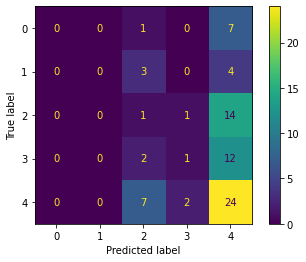

In [52]:
pcm = metrics.ConfusionMatrixDisplay(confusion_matrix=all_stats[min_v]["cm"])
pcm.plot()
plt.show()

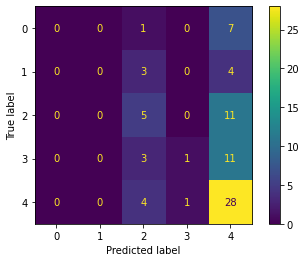

In [53]:
pcm = metrics.ConfusionMatrixDisplay(confusion_matrix=all_stats[max_v]["cm"])
pcm.plot()
plt.show()